In [1]:
import sys, glob, time
import collections

import numpy as np
import tensorflow as tf
import pandas as pd 

import pybullet as p
from pyb.pybullet_robot import PyBulletRobot

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# plots loss and metrics for training and validation
def plot_fh(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [3]:
# plots given data_dict
def live_plot(data_dict, figsize=(17,15), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()

In [4]:
gui = True
r = PyBulletRobot(4, 4, render=gui)

*** Initializing PyBulletRobot(ns=4, render=True) ...
*** Initializing PyBulletRobot() done


In [5]:
def mk_model(N, L, activation):
    inputs = layer = tf.keras.Input(shape=(7,))
    
    for _ in range(L):
        layer = tf.keras.layers.Dense(N, activation=activation)(layer)
        
    outputs = tf.keras.layers.Dense(6, activation='tanh')(layer)

    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

#print(model.summary())

In [6]:
# X - cam_p + cam_o (quaternion) = 7
# Y - phis - 3 * 2 = 6
def mk_random_xy(M):
    X = np.zeros((M, 7))
    Y = np.zeros((M, 6))

    Y[:,0] = np.random.uniform(low=-0.6, high=0, size=(M))
    Y[:,2] = np.random.uniform(low=0.3, high=0.8, size=(M))
    Y[:,4] = np.random.uniform(low=0.3, high=0.8, size=(M))

    Y[:,1] = np.random.uniform(low=-0.6, high=0.6, size=(M))
    Y[:,3] = np.random.uniform(low=-0.6, high=0.6, size=(M))
    Y[:,5] = np.random.uniform(low=-0.6, high=0.6, size=(M))

    for i in range(M):
        phis = Y[i,:].reshape(-1, 2)
        phis = np.append(phis, [phis[-1]], axis=0) # add another axis moving in sync with the last one
        
        r.step(phis)

        cam_p, cam_o = r.getHeadcamPO()
        X[i] = cam_p + cam_o
    
    return X, Y

#mk_xy(1)

In [8]:
X, Y = mk_random_xy(5000000)
print("Shape of X=%s and Y=%s" % (X.shape, Y.shape))    

Shape of X=(5000000, 7) and Y=(5000000, 6)


In [ ]:
np.savez("xy-%d.npz" % X.shape[0], X=X, Y=Y)

In [11]:
def train_and_save(X, Y, N=128, L=4, activation="relu"):
    m_fname = 'pose2phis-%d-%d-%s-%d' % (N, L, activation, X.shape[0])
    fh_fname = "%s.fh.npz" % m_fname
    
    model = mk_model(N, L, activation)
    
    print("# Training %s" % m_fname)
    fh = model.fit(X, Y, epochs=12, shuffle=True, validation_split=0.002, verbose=1)
    plot_fh(fh)

    model.save(m_fname)
    np.savez(fh_fname, fh=fh)

    print("# Trained model saved in %s, fit history saved in %s" % (m_fname, fh_fname))
    
    return model

# Training pose2phis-128-4-relu-5000000
Train on 4990000 samples, validate on 10000 samples
Epoch 1/12
4990000/4990000 [==============================] - 399s 80us/sample - loss: 0.0057 - mae: 0.0449 - val_loss: 0.0045 - val_mae: 0.0378
Epoch 2/12
4990000/4990000 [==============================] - 409s 82us/sample - loss: 0.0045 - mae: 0.0379 - val_loss: 0.0040 - val_mae: 0.0340
Epoch 3/12
4990000/4990000 [==============================] - 420s 84us/sample - loss: 0.0042 - mae: 0.0358 - val_loss: 0.0048 - val_mae: 0.0388
Epoch 4/12
4990000/4990000 [==============================] - 411s 82us/sample - loss: 0.0040 - mae: 0.0348 - val_loss: 0.0037 - val_mae: 0.0320
Epoch 5/12
4990000/4990000 [==============================] - 402s 81us/sample - loss: 0.0039 - mae: 0.0341 - val_loss: 0.0037 - val_mae: 0.0323
Epoch 6/12
4990000/4990000 [==============================] - 469s 94us/sample - loss: 0.0038 - mae: 0.0334 - val_loss: 0.0037 - val_mae: 0.0322
Epoch 7/12
4990000/4990000 [==========

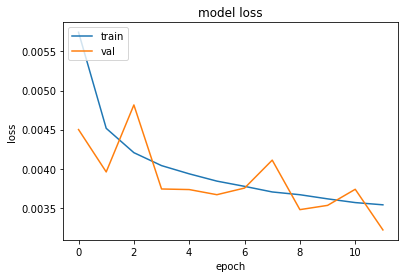

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: pose2phis-128-4-relu-5000000\assets


TypeError: can't pickle _thread.RLock objects

In [12]:
train_and_save(X, Y)

In [ ]:
MAX_ALPHA = np.pi/4
D_ALPHA = 0.025

def set_robot_pose(model, alpha):
    cam_p = [0.23, 0.0, 0.67]
    
    # getQuaternionFromEuler (the roll around the X, pitch around Y and yaw around the Z axis)
    cam_o = r.euler2orn(alpha, np.pi/2, 0)
    cam_v, cam_u = r.orn2vu(cam_o)

    test_X = np.array([cam_p + cam_o], dtype=np.float32)
    pred_phis = model.predict(test_X)
    
    pred_phis = pred_phis.reshape(-1, 2)
    pred_phis = np.append(pred_phis, [pred_phis[-1]], axis=0)    
    r.step(pred_phis)
    pvu = r.getHeadcamPVU()

    #r.getCameraImage()
    return pvu, pred_phis.reshape(-1), [cam_p, cam_v, cam_u]

def sweep_model(model):
    data_v = collections.defaultdict(list)
    data_u = collections.defaultdict(list)
    data_phis = collections.defaultdict(list)

    for alpha in np.arange(-MAX_ALPHA, MAX_ALPHA+D_ALPHA, D_ALPHA):
        pvu0, phis, pvu1 = set_robot_pose(model, alpha)

        if True:
            data_v['cam_vx0'].append(pvu0[1][0])
            data_v['cam_vx1'].append(pvu1[1][0])
            data_v['cam_vy0'].append(pvu0[1][1])
            data_v['cam_vy1'].append(pvu1[1][1])
            data_v['cam_vz0'].append(pvu0[1][2])
            data_v['cam_vz1'].append(pvu1[1][2])

        if True:
            data_u['cam_ux0'].append(pvu0[2][0])
            data_u['cam_ux1'].append(pvu1[2][0])
            data_u['cam_uy0'].append(pvu0[2][1])
            data_u['cam_uy1'].append(pvu1[2][1])
            data_u['cam_uz0'].append(pvu0[2][2])
            data_u['cam_uz1'].append(pvu1[2][2])

        if True:
            for i in range(phis.shape[0]-2):
                data_phis['phi%d' % i].append(phis[i])

    return data_v, data_u, data_phis

In [ ]:
#model = tf.keras.models.load_model('pose2phis-128-4-relu-10000000')
data_v, data_u, data_phis = sweep_model(model)

In [ ]:
live_plot(data_v)

In [ ]:
live_plot(data_u)

In [ ]:
live_plot(data_phis)